Gerekli Kütüphane Kurulumları

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [3]:
import os
import time
import uuid   #Kendimize özel bir kimlik tanımlıyoruz(id)
import cv2
from google.colab import output
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np

Kendimize Özel Bir ID tanımlama

In [ ]:
uuid.uuid1()  #Örnek Olarak

UUID('64b5e9f8-b17a-11ee-8f0e-0242ac1c000c')

Veri Setini Tutacağımız Bir Klasör Oluşturuyoruz

In [ ]:
!mkdir data
!mkdir data/images
!mkdir data/labels

In [144]:
IMAGES_PATH = os.path.join("data","images")
number_images = 30
base_path = '/content/data/images'

In [142]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [145]:
def take_photo_multiple_times(num_photos=10, base_path=base_path, quality=0.8):
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    filenames = []

    for i in range(1, num_photos + 1):
        id=uuid.uuid1()
        filename = os.path.join(base_path, f'{id}.jpg')
        take_photo(filename=filename, quality=quality)
        filenames.append(filename)

    return filenames

In [ ]:
take_photo_multiple_times()

**!!** Dışarıdan kendimizde veri setini yükleyebiliriz yukarıda bulunan kodlar çalışma ortamında yapabilmek için , etiketleme işlemini Labelme ile gerçekleştirilebilir Colab ortamında Labelme çalışmadığından kendi bilgisayarınızda etiketleme işlemini yapabilirsiniz.

Drive Bağlama

In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Dışarıdan Veri Yükleme

In [5]:
!unzip -q /content/drive/MyDrive/Dataset/data.zip

Veri Kümesi İnceleme ve Görüntü Yükleme Fonksiyonu Oluşturma

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

GPU bellek kullanımı erişimi

In [7]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [8]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Veri Yükleme

In [9]:
images = tf.data.Dataset.list_files("/content/data/train/images/*.jpg",shuffle=False)

In [10]:
images.as_numpy_iterator().next()

b'/content/data/train/images/WIN_20240112_21_48_17_Pro.jpg'

In [11]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

Görüntüleri Görselleştirme

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

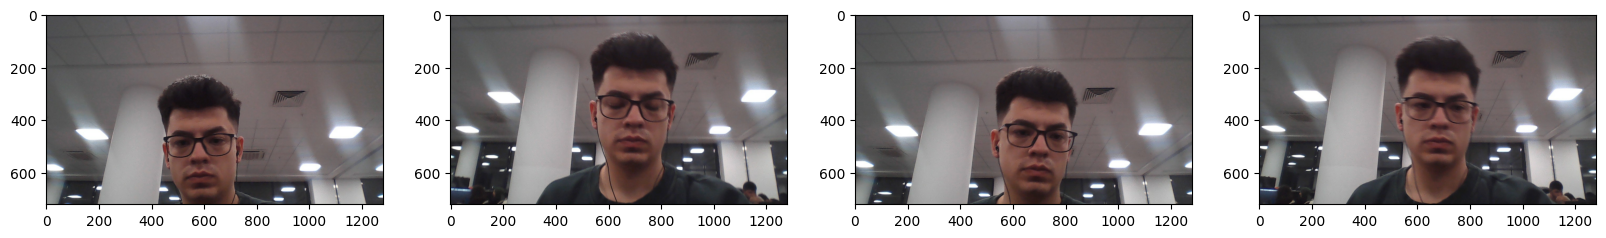

In [16]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

Görüntülere Büyütme Uygulama

In [17]:
import albumentations as alb

In [18]:

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [19]:
img = cv2.imread(os.path.join('data','train', 'images','/content/data/train/images/WIN_20240112_21_48_17_Pro.jpg'))


In [20]:
img

array([[[ 86,  77,  80],
        [ 87,  78,  81],
        [ 86,  77,  80],
        ...,
        [ 83,  83,  83],
        [ 85,  85,  85],
        [ 85,  85,  85]],

       [[ 84,  75,  78],
        [ 84,  75,  78],
        [ 84,  75,  78],
        ...,
        [ 82,  82,  82],
        [ 82,  82,  82],
        [ 82,  82,  82]],

       [[ 82,  73,  76],
        [ 82,  73,  76],
        [ 82,  73,  76],
        ...,
        [ 80,  80,  80],
        [ 80,  80,  80],
        [ 80,  80,  80]],

       ...,

       [[154, 153, 155],
        [155, 154, 156],
        [152, 151, 153],
        ...,
        [ 51,  51,  51],
        [ 52,  52,  52],
        [ 52,  52,  52]],

       [[153, 152, 156],
        [155, 154, 158],
        [153, 152, 156],
        ...,
        [ 49,  51,  51],
        [ 50,  52,  52],
        [ 50,  52,  52]],

       [[152, 151, 155],
        [155, 154, 158],
        [154, 153, 157],
        ...,
        [ 49,  51,  51],
        [ 49,  51,  51],
        [ 50,  52,  52]]

In [21]:
with open(os.path.join('data', 'train', 'labels', '/content/data/train/labels/WIN_20240112_21_48_17_Pro.json'), 'r') as f:
    label = json.load(f)

In [22]:
label["shapes"][0]["points"]

[[390.7936507936508, 218.73015873015873], [759.047619047619, 706.031746031746]]

#Koordinat Çıkarma

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [24]:
coords


[390.7936507936508, 218.73015873015873, 759.047619047619, 706.031746031746]

In [25]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [26]:
coords

[0.30530753968253965,
 0.3037918871252205,
 0.5930059523809523,
 0.9805996472663139]

In [27]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [28]:
augmented['bboxes'][0][2:]

(1.0, 0.9911816578483245)

In [29]:
augmented['bboxes']

[(0.681763668430335, 0.0, 1.0, 0.9911816578483245)]

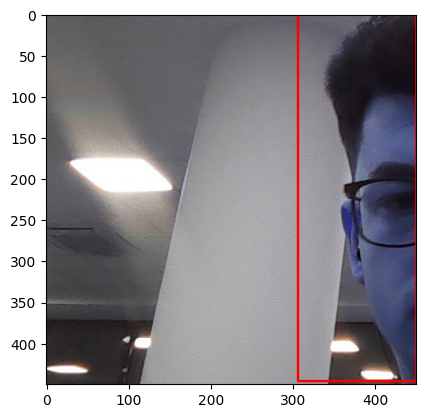

In [30]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Büyütme İşlem Hattını Oluşturma ve Çalıştırma

In [38]:
!mkdir aug_data2

!mkdir aug_data2/test
!mkdir aug_data2/test/images
!mkdir aug_data2/test/labels

!mkdir aug_data2/train
!mkdir aug_data2/train/images
!mkdir aug_data2/train/labels

!mkdir aug_data2/val
!mkdir aug_data2/val/images
!mkdir aug_data2/val/labels

In [39]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('/content/data', partition, 'images')):
        img = cv2.imread(os.path.join('/content/data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data2', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data2', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.3580109126984127, 0.2729276895943563, 0.055734586133391065, 0.9986111111111111, 'face'].
x_max is less than or equal to x_min for bbox [0.16703869047619047, 0.3743386243386244, 0.0019350459482038395, 0.9986111111111111, 'face'].
x_max is less than or equal to x_min for bbox [0.6128472222222222, 0.3324514991181658, 0.4016937348890991, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.6568700396825397, 0.4944885361552029, 0.43365575396825395, 0.008377425044091735, 'face'].


In [41]:
train_images = tf.data.Dataset.list_files('/content/aug_data2/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)


test_images = tf.data.Dataset.list_files('/content/aug_data2/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('/content/aug_data2/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

train_images.as_numpy_iterator().next()

array([[[0.35      , 0.30588236, 0.30441177],
        [0.35049018, 0.30343136, 0.30343136],
        [0.3529412 , 0.30588236, 0.30588236],
        ...,
        [0.36960784, 0.33431372, 0.3382353 ],
        [0.3622549 , 0.32696077, 0.33088234],
        [0.3622549 , 0.32696077, 0.33088234]],

       [[0.34460783, 0.30637255, 0.3019608 ],
        [0.34509805, 0.30588236, 0.3019608 ],
        [0.3598652 , 0.31280637, 0.31280637],
        ...,
        [0.36911765, 0.3377451 , 0.32990196],
        [0.36519608, 0.32990196, 0.33382353],
        [0.3632353 , 0.32794118, 0.33284312]],

       [[0.3408701 , 0.30557597, 0.30949754],
        [0.34901962, 0.30980393, 0.3137255 ],
        [0.34552696, 0.30631128, 0.31023285],
        ...,
        [0.37254903, 0.34117648, 0.33333334],
        [0.36911765, 0.33382353, 0.34460783],
        [0.36439952, 0.3291054 , 0.3408701 ]],

       ...,

       [[0.33382353, 0.30245098, 0.29460785],
        [0.33719364, 0.30533087, 0.29895833],
        [0.33670342, 0

Labellerın Hazırlanması

In [42]:
def load_labels(label_path):
  with open(label_path.numpy(),"r",encoding="utf-8") as f:
    label = json.load(f)

    return [label["class"]],label["bbox"]

In [43]:
train_labels = tf.data.Dataset.list_files("/content/aug_data2/train/labels/*.json",shuffle=False)

In [44]:
train_labels.as_numpy_iterator().next()

b'/content/aug_data2/train/labels/WIN_20240112_21_48_17_Pro.0.json'

In [52]:
train_labels = tf.data.Dataset.list_files("/content/aug_data2/train/labels/*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
test_labels = tf.data.Dataset.list_files("/content/aug_data2/test/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [57]:
val_labels = tf.data.Dataset.list_files('/content/aug_data2/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [58]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3354, 0.1594, 1.    , 1.    ], dtype=float16))

Etiket ve Resim Örneklerini Birleştirme

In [59]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(3960, 3960, 480, 480, 1200, 1200)

In [60]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [62]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [63]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = train.shuffle(1000)
val = train.batch(8)
val = train.prefetch(4)

In [64]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [68]:
#Örnek
data_samples = train.as_numpy_iterator()


In [72]:
res = data_samples.next()

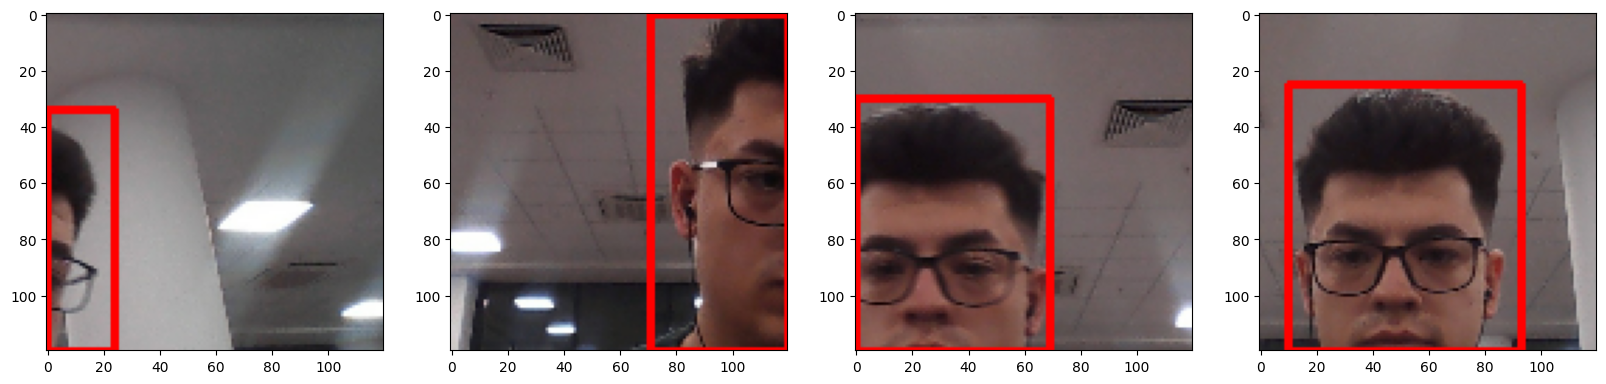

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

Model Yükleme

In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [75]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [76]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [77]:
def build_model():
  input_layer = Input(shape=(120,120,3))

  vgg = VGG16(include_top=False)(input_layer)

  #Sınıflandırma Modeli

  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048,activation="relu")(f1)
  class2 = Dense(1,activation="sigmoid")(class1)

  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048,activation="relu")(f1)
  regress2 = Dense(4,activation="sigmoid")(regress1)

  facetracker = Model(inputs=input_layer,outputs=[class2,regress2])
  return facetracker

In [78]:
facetracker = build_model()

In [79]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [83]:
#Test etme modeli
X, y = train.as_numpy_iterator().next()
classes , coords = facetracker.predict(X)
classes , coords

1/1 [==============================] - 0s 19ms/step


(array([[0.4027795 ],
        [0.43783826],
        [0.47842264],
        [0.531329  ],
        [0.44336304],
        [0.39870068],
        [0.44949457],
        [0.46860707]], dtype=float32),
 array([[0.52044404, 0.5292358 , 0.40572608, 0.46494818],
        [0.5383808 , 0.5691489 , 0.43446946, 0.45089042],
        [0.4893624 , 0.5930849 , 0.4627736 , 0.45339328],
        [0.5099363 , 0.4988199 , 0.43804953, 0.38912776],
        [0.44649675, 0.61281466, 0.5355211 , 0.3926589 ],
        [0.50440127, 0.47075957, 0.49264318, 0.4140566 ],
        [0.55641794, 0.60331875, 0.43857256, 0.387994  ],
        [0.5261394 , 0.5796808 , 0.43719575, 0.48266336]], dtype=float32))

Kayıpları ve Optimize Edicileri Tanımlama

In [84]:
len(train)

495

In [85]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [87]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

Yerelleştirme Kaybı ve Sınıflandırma Kaybı Oluşturma

In [89]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [90]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [91]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=11.133814>

In [92]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.76818717>

In [93]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=11.133814>

Train

In [94]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [95]:
model = FaceTracker(facetracker)

In [97]:
model.compile(opt,classloss,regressloss)

In [98]:
!mkdir logs

In [99]:
logdir = "/content/logs"

In [100]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [101]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
495/495 [==============================] - 66s 102ms/step - total_loss: 0.7909 - class_loss: 0.1558 - regress_loss: 0.7130 - val_total_loss: 0.1287 - val_class_loss: 0.0314 - val_regress_loss: 0.1130
Epoch 2/10
495/495 [==============================] - 55s 99ms/step - total_loss: 0.4430 - class_loss: 0.1112 - regress_loss: 0.3874 - val_total_loss: 0.1791 - val_class_loss: 0.0773 - val_regress_loss: 0.1405
Epoch 3/10
495/495 [==============================] - 79s 144ms/step - total_loss: 0.3653 - class_loss: 0.0977 - regress_loss: 0.3165 - val_total_loss: 0.0447 - val_class_loss: 5.8778e-04 - val_regress_loss: 0.0444
Epoch 4/10
495/495 [==============================] - 62s 106ms/step - total_loss: 0.3071 - class_loss: 0.0866 - regress_loss: 0.2638 - val_total_loss: 0.0554 - val_class_loss: 0.0318 - val_regress_loss: 0.0395
Epoch 5/10
495/495 [==============================] - 56s 100ms/step - total_loss: 0.2602 - class_loss: 0.0777 - regress_loss: 0.2214 - val_total_loss: 0

Performans

In [102]:
hist.history

{'total_loss': [0.2856375277042389,
  0.7252265810966492,
  0.08407179266214371,
  0.13192997872829437,
  0.01748770847916603,
  0.0681920126080513,
  0.24131670594215393,
  0.05465869605541229,
  0.481840044260025,
  0.021343901753425598],
 'class_loss': [0.1005348190665245,
  0.3320084512233734,
  0.013567464426159859,
  0.024555720388889313,
  0.0016728655900806189,
  0.023617153987288475,
  0.12304861098527908,
  0.03556827828288078,
  0.18898169696331024,
  0.0034202723763883114],
 'regress_loss': [0.23537012934684753,
  0.5592223405838013,
  0.07728806138038635,
  0.11965212225914001,
  0.016651276499032974,
  0.05638343468308449,
  0.1797924041748047,
  0.03687455505132675,
  0.3873491883277893,
  0.019633766263723373],
 'val_total_loss': [0.12870480120182037,
  0.17912164330482483,
  0.04474225267767906,
  0.055389367043972015,
  0.13522456586360931,
  1.3959444761276245,
  0.02099841646850109,
  0.06395168602466583,
  0.025163184851408005,
  0.027174023911356926],
 'val_class_

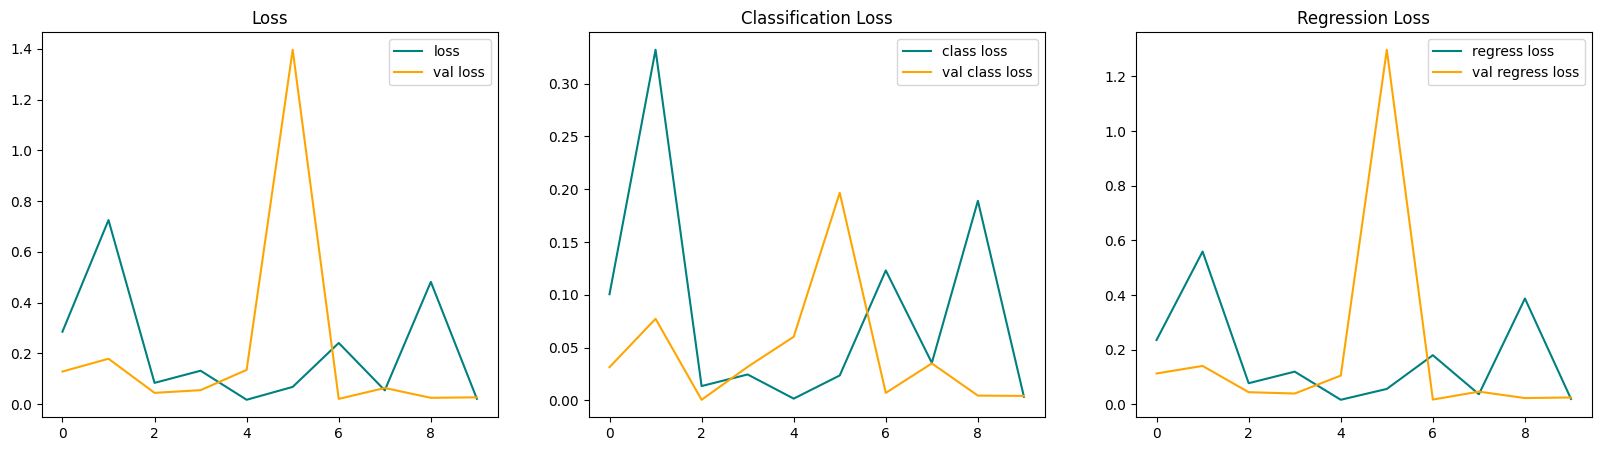

In [103]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Tahmin Yaptırma

In [104]:
test_data = test.as_numpy_iterator()

In [105]:
test_sample = test_data.next()

In [106]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 27ms/step


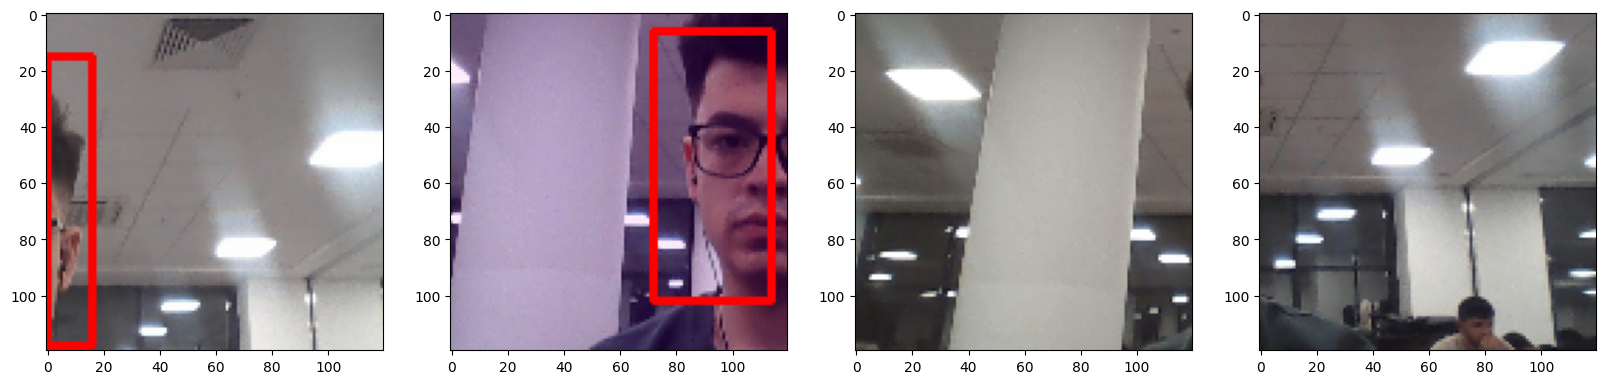

In [107]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

Model Kaydetme

In [108]:
from tensorflow.keras.models import load_model

In [111]:
!mkdir save_model

In [109]:
file_path ="/content/save_model"

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('/content/facetracker.h5')